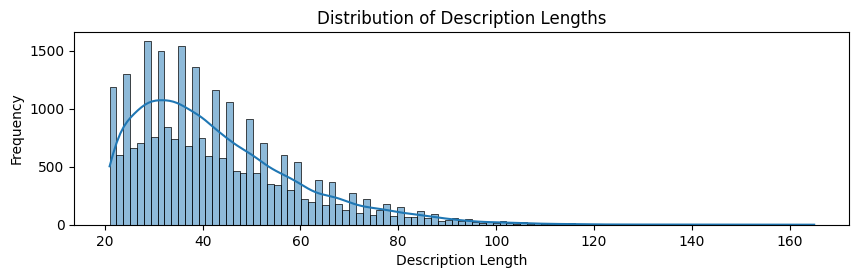

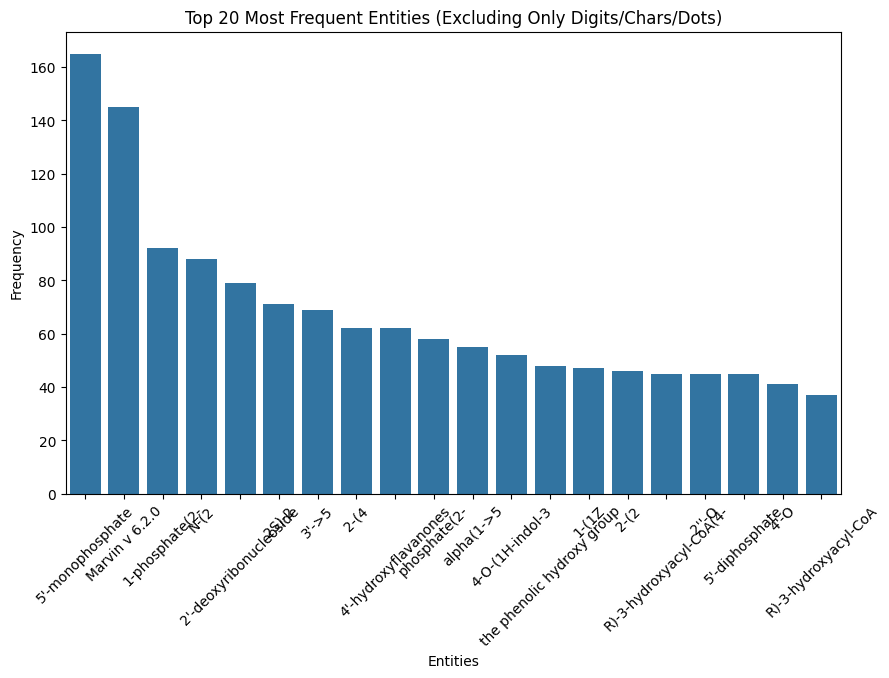

In [9]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

path = 'PATH TO DATA'

data = pd.read_csv(path+'train.tsv', sep='\t', header=None, names=['CID', 'Description'])

data['Desc_Length'] = data['Description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,2.5))
sns.histplot(data['Desc_Length'], kde=True)
plt.title('Distribution of Description Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

nlp = spacy.load('en_core_web_sm')


def is_only_digits_chars_or_dots(entity):
    return re.fullmatch(r'[\w.,-]+', entity) is not None


all_entities = []
for doc in nlp.pipe(data['Description']):
    for ent in doc.ents:
        if not is_only_digits_chars_or_dots(ent.text): 
            all_entities.append(ent.text)

entity_freq = Counter(all_entities)

most_common_entities = entity_freq.most_common(20)

plt.figure(figsize=(10,6))
sns.barplot(x=[entity for entity, freq in most_common_entities], y=[freq for entity, freq in most_common_entities])
plt.title('Top 20 Most Frequent Entities (Excluding Only Digits/Chars/Dots)')
plt.xticks(rotation=45)
plt.xlabel('Entities')
plt.ylabel('Frequency')
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
sns.barplot(x=[entity for entity, freq in most_common_entities], y=[freq for entity, freq in most_common_entities])
plt.title('Top 20 Most Frequent Entities (Excluding Only Digits/Chars/Dots)')
plt.xticks(rotation=45)
plt.xlabel('Entities')
plt.ylabel('Frequency')
plt.show()

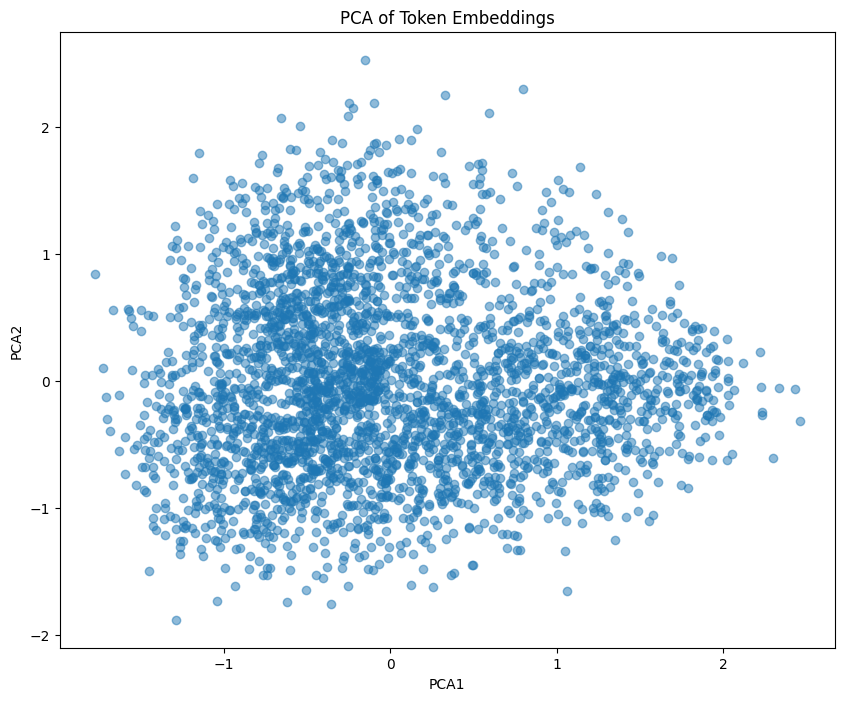

In [8]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

token_embedding_dict = np.load(path+'token_embedding_dict.npy', allow_pickle=True)[()]

embeddings = np.array(list(token_embedding_dict.values()))

pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], alpha=0.5)
plt.title('PCA of Token Embeddings')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show()


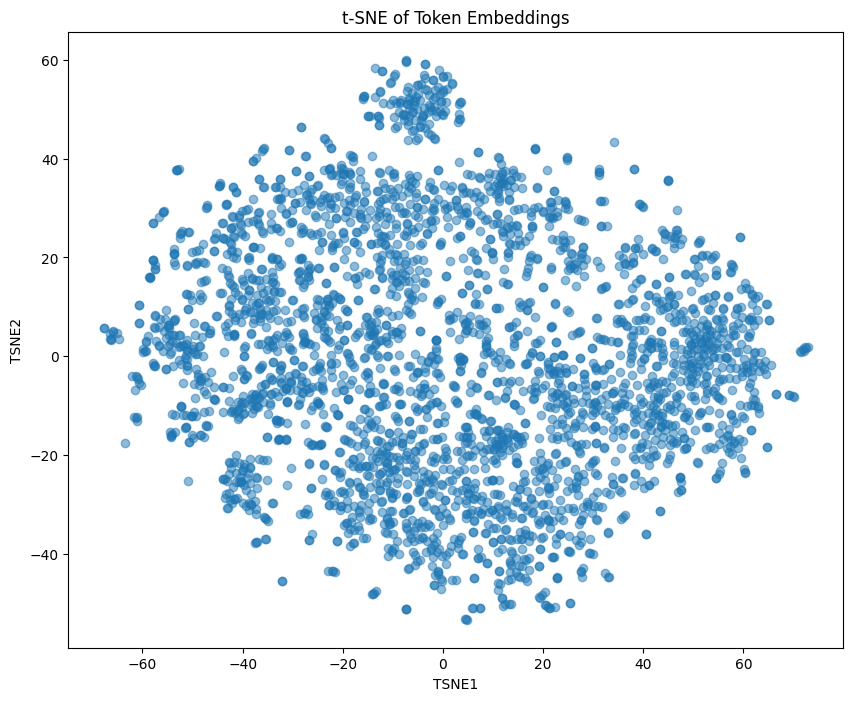

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title('t-SNE of Token Embeddings')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()


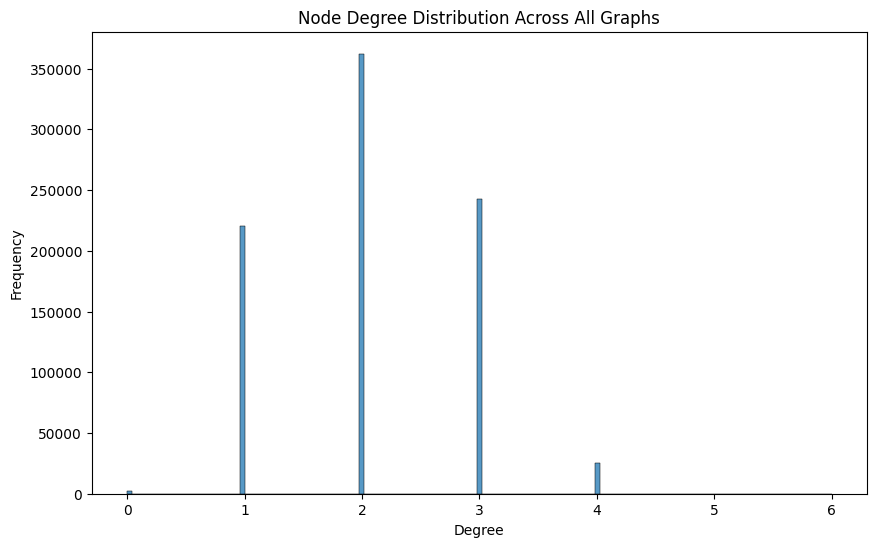

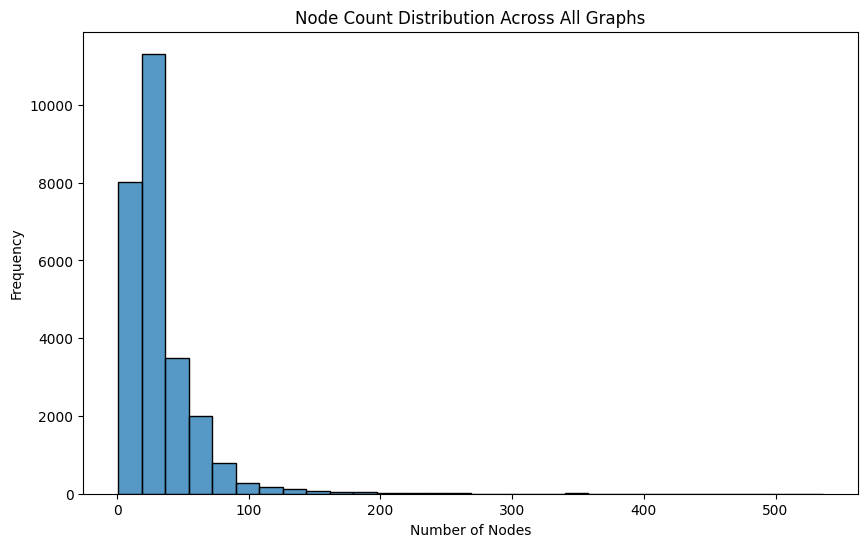

In [31]:
def read_graph_from_pt(file_path):
    data = torch.load(file_path)
    num_nodes = data.num_nodes  
    edge_index = data.edge_index
    if edge_index.numel() == 0:
        return torch.zeros(data.num_nodes, dtype=torch.long), num_nodes
    degrees = edge_index[0].bincount(minlength=data.num_nodes)
    return degrees, num_nodes

folder_path = path + 'processed/train' 

all_degrees = []
node_counts = []  

for filename in os.listdir(folder_path):
    if 'data_' not in filename:
        continue
    if filename.endswith('.pt'):
        file_path = os.path.join(folder_path, filename)
        degrees, num_nodes = read_graph_from_pt(file_path)
        all_degrees.extend(degrees.tolist())
        node_counts.append(num_nodes)

plt.figure(figsize=(10, 6))
sns.histplot(all_degrees, kde=False)
plt.title('Node Degree Distribution Across All Graphs')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(node_counts, kde=False, bins=30) 
plt.title('Node Count Distribution Across All Graphs')
plt.xlabel('Number of Nodes')
plt.ylabel('Frequency')
plt.show()


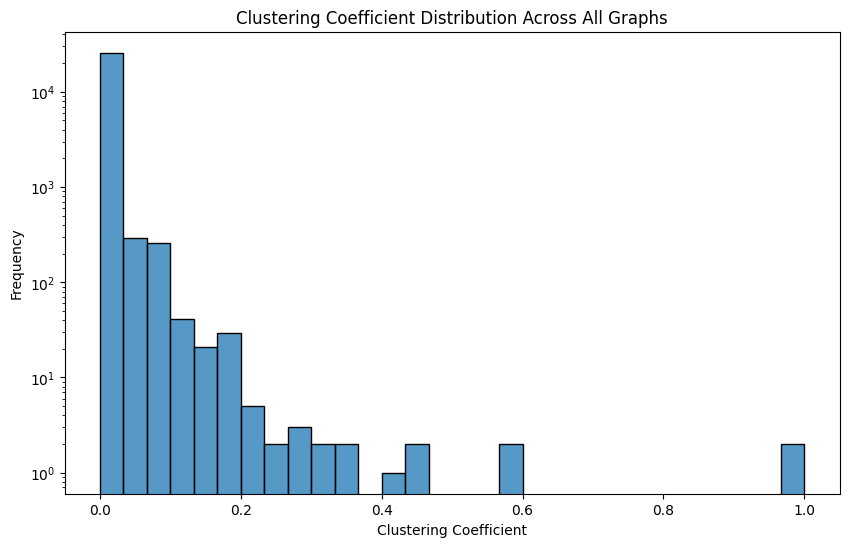

In [33]:
import torch
from torch_geometric.utils import to_networkx
import networkx as nx

def read_graph_for_clustering(file_path):
    data = torch.load(file_path)
    G = to_networkx(data, to_undirected=True)
    if len(G) == 0: 
        return 0
    clustering_coeff = nx.average_clustering(G)
    return clustering_coeff

folder_path = path + 'processed/train' 

clustering_coeffs = []

for filename in os.listdir(folder_path):
    if 'data_' not in filename:
        continue
    if filename.endswith('.pt'):
        file_path = os.path.join(folder_path, filename)
        coeff = read_graph_for_clustering(file_path)
        clustering_coeffs.append(coeff)

plt.figure(figsize=(10, 6))
sns.histplot(clustering_coeffs, kde=False, bins=30, log=True)
plt.title('Clustering Coefficient Distribution Across All Graphs')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Frequency')
plt.show()


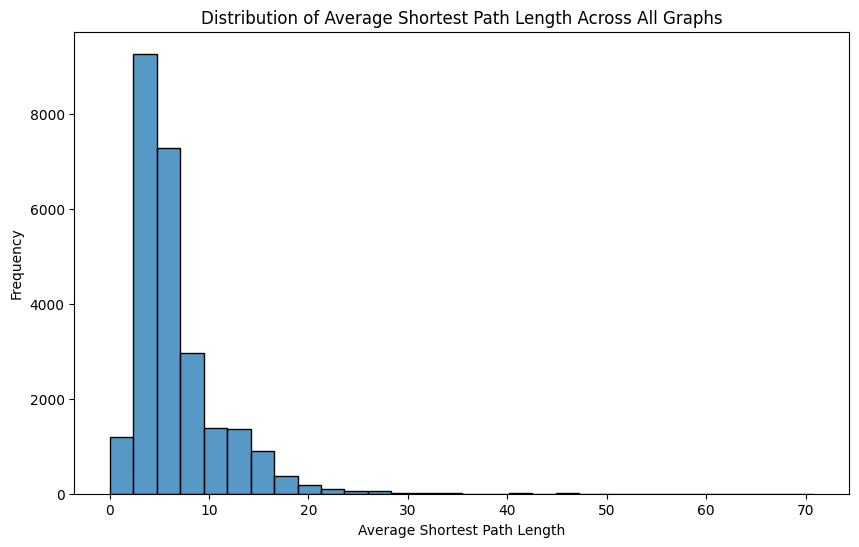

In [34]:
def read_graph_for_shortest_path(file_path):
    data = torch.load(file_path)
    G = to_networkx(data, to_undirected=True)
    if len(G) == 0 or nx.is_connected(G) == False:
        return float('inf')
    avg_shortest_path_length = nx.average_shortest_path_length(G)
    return avg_shortest_path_length

avg_shortest_path_list = []

for filename in os.listdir(folder_path):
    if 'data_' not in filename:
        continue
    if filename.endswith('.pt'):
        file_path = os.path.join(folder_path, filename)
        avg_path_length = read_graph_for_shortest_path(file_path)
        if avg_path_length != float('inf'):
            avg_shortest_path_list.append(avg_path_length)

plt.figure(figsize=(10, 6))
sns.histplot(avg_shortest_path_list, kde=False, bins=30)
plt.title('Distribution of Average Shortest Path Length Across All Graphs')
plt.xlabel('Average Shortest Path Length')
plt.ylabel('Frequency')
plt.show()


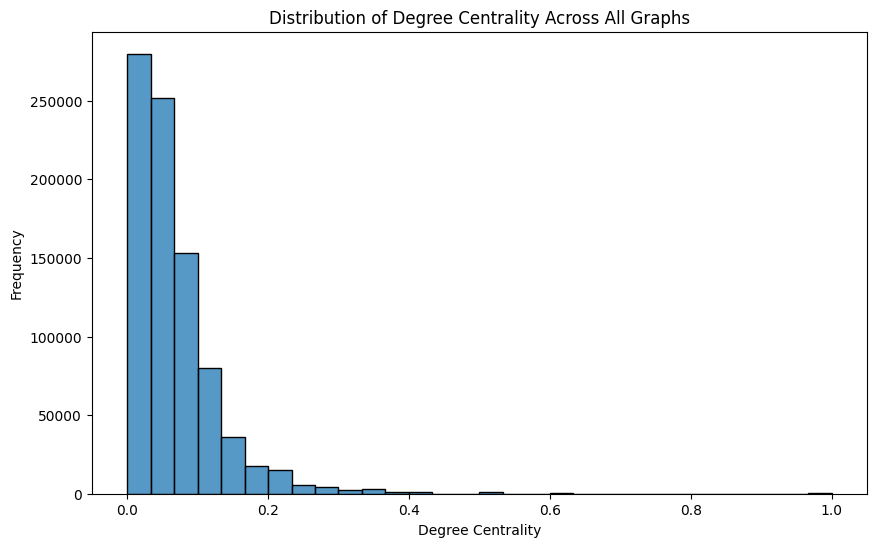

In [35]:
def read_graph_for_degree_centrality(file_path):
    data = torch.load(file_path)
    G = to_networkx(data, to_undirected=True)
    if len(G) == 0:
        return []
    degree_centrality = nx.degree_centrality(G)
    return list(degree_centrality.values())

degree_centrality_list = []

for filename in os.listdir(folder_path):
    if 'data_' not in filename:
        continue
    if filename.endswith('.pt'):
        file_path = os.path.join(folder_path, filename)
        centrality_values = read_graph_for_degree_centrality(file_path)
        degree_centrality_list.extend(centrality_values)

plt.figure(figsize=(10, 6))
sns.histplot(degree_centrality_list, kde=False, bins=30)
plt.title('Distribution of Degree Centrality Across All Graphs')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')
plt.show()


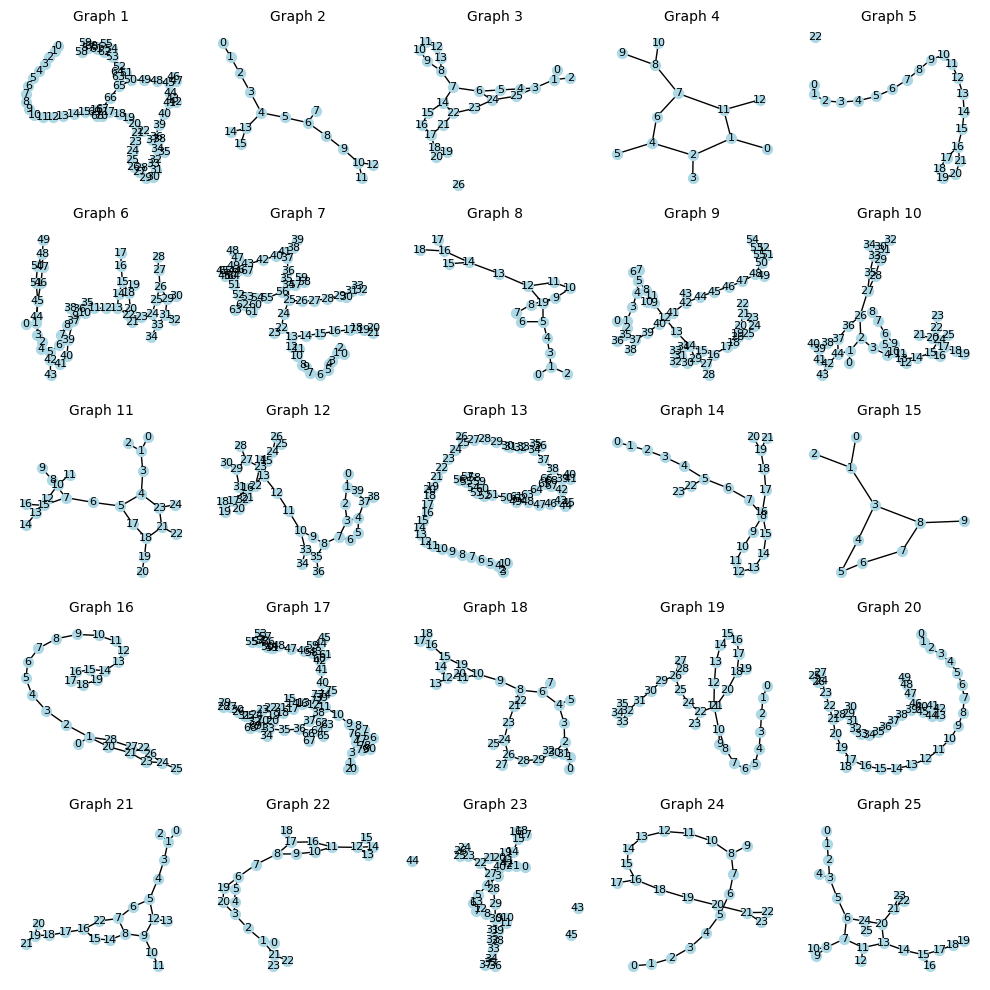

In [11]:
import torch
import os
import random
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def load_graph(file_path):
    data = torch.load(file_path)
    return to_networkx(data, to_undirected=True)

folder_path = path + 'processed/train' 

all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.pt')]

selected_files = random.sample(all_files, 25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
axes = axes.flatten()

for i, file in enumerate(selected_files):
    G = load_graph(file)
    ax = axes[i]
    nx.draw(G, ax=ax, with_labels=True, node_color='lightblue', node_size=50, font_size=8)
    ax.set_title(f"Graph {i+1}", size=10)

plt.tight_layout()
plt.show()